# Metric Learning Homework

### Author: Denys Herasymuk

This notebook includes evaluation for two models:
* Plain pre-trained ImageNet backbone
* Fine-tuned with vanilla Cross Entropy and classification approach

In [ ]:
from IPython.display import Image, HTML, clear_output
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

## Install libraries

In [ ]:
# !pip install pytorch-metric-learning
# !pip install faiss-gpu
# clear_output()

In [ ]:
# !pip install albumentations
# !pip install annoy
# !pip install ml_metrics
# clear_output()

## Download dataset

In [ ]:
# !wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1TclrpQOF_ullUP99wk_gjGN8pKvtErG8' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TclrpQOF_ullUP99wk_gjGN8pKvtErG8" -O stanford_online_products.zip && rm -rf /tmp/cookies.txt

In [ ]:
# !unzip ./stanford_online_products.zip
# clear_output()

In [ ]:
!ls ./Stanford_Online_Products/

bicycle_final		Ebay_final.txt	  lamp_final	  stapler_final
bicycle_final.txt	Ebay_info.txt	  lamp_final.txt  stapler_final.txt
cabinet_final		Ebay_test.txt	  LICENSE	  table_final
cabinet_final.txt	Ebay_train.txt	  mug_final	  table_final.txt
chair_final		fan_final	  mug_final.txt   toaster_final
chair_final.txt		fan_final.txt	  README	  toaster_final.txt
coffee_maker_final	kettle_final	  sofa_final
coffee_maker_final.txt	kettle_final.txt  sofa_final.txt


In [ ]:
!head ./Stanford_Online_Products/Ebay_train.txt -n 10

image_id class_id super_class_id path
1 1 1 bicycle_final/111085122871_0.JPG
2 1 1 bicycle_final/111085122871_1.JPG
3 1 1 bicycle_final/111085122871_2.JPG
4 1 1 bicycle_final/111085122871_3.JPG
5 1 1 bicycle_final/111085122871_4.JPG
6 1 1 bicycle_final/111085122871_5.JPG
7 1 1 bicycle_final/111085122871_6.JPG
8 1 1 bicycle_final/111085122871_7.JPG
9 2 1 bicycle_final/111265328556_0.JPG


In [ ]:
# !git clone https://github.com/denysgerasymuk799/UCU_CV_Metric_Learning_HW.git

In [ ]:
# !git pull

## Import libraries

In [ ]:
import cv2
import random
import numpy as np
import pandas as pd
import albumentations as albu
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2 as ToTensor
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
repo_path = '/content/UCU_CV_Metric_Learning_HW'
if os.getcwd() != repo_path:
  os.chdir(repo_path)
  print('Current working dir: ', os.getcwd())

Current working dir:  /content/UCU_CV_Metric_Learning_HW


In [ ]:
from src.data_preparation.prepare_datasets import get_data_transforms, get_files_metadata_dfs, get_datasets, get_data_loaders
from src.models.model_types import ModelTypes
from src.models.resenet_initializer import ResNetInitializer
from src.utils.annoy_utils import get_embedding, build_index, load_index
from src.utils.viz_utils import normalized_img_tensor_to_rgb, show_img, show_retrieval
from src.utils.fine_tuning import complex_criterion, fine_tune_model
from src.utils.model_evaluation import evaluate

## Define configs

In [ ]:
SEED = 42
VAL_FRACTION = 0.2
BATCH_SIZE = 128
NUM_WORKERS = 16
METRICS_K = 5

INDEX_MODEL_OUTPUT_SIZE = 512  # Length of item vector that will be indexed

ROOT_DATA_DIR = '/content/Stanford_Online_Products'
GDRIVE_DATA_DIR = '/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/Metric_Learning_HW1/results'

In [ ]:
models_metrics_df = pd.DataFrame(columns=[
    'Model_Name',
    'Accuracy_Class_ID',
    'Accuracy_Superclass_ID',
    f'mAP@{METRICS_K}_Class_ID',
    f'mAP@{METRICS_K}_Superclass_ID'
])

## Create data loaders

In [ ]:
files_metadata_dfs = get_files_metadata_dfs(ROOT_DATA_DIR, VAL_FRACTION, SEED)

Train shape:  (47640, 4)
Val shape:  (11911, 4)
Test shape:  (60502, 4)


In [ ]:
num_superclasses = max([len(files_metadata_dfs[phase]['super_class_id'].unique()) for phase in ['train', 'val', 'test']])
print('Number of superclasses: ', num_superclasses)
num_classes = max([len(files_metadata_dfs[phase]['class_id'].unique()) for phase in ['train', 'val', 'test']])
print('Number of classes: ', num_classes)

Number of superclasses:  12
Number of classes:  11318


In [ ]:
datasets = get_datasets(files_metadata_dfs, ROOT_DATA_DIR)
data_loaders = get_data_loaders(datasets, BATCH_SIZE, NUM_WORKERS)
dataset_sizes = {
    'train': len(datasets['train']),
    'val': len(datasets['val']),
}

Class id: 908
Super Class id: 2



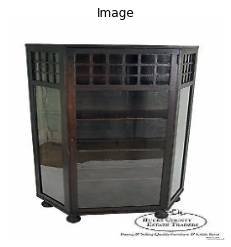

In [ ]:
show_img(datasets['train'], 4)

Class id: 11319
Super Class id: 1



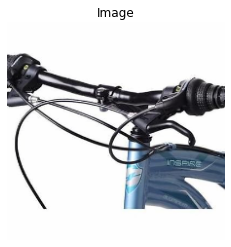

In [ ]:
show_img(datasets['test'], 4)

## Task 1: Plain pre-trained ImageNet backbone

In [ ]:
plain_resnet18_conf = ResNetInitializer(ModelTypes.PLAIN_BACKBONE, num_superclasses, num_classes)
# Set model to evaluation mode
plain_resnet18_conf.model.eval()

### Build an Index

In [ ]:
annoy_index = build_index(plain_resnet18_conf.model, datasets['train'], INDEX_MODEL_OUTPUT_SIZE,
                          plain_resnet18_conf.model_name, num_trees=12, data_dir=GDRIVE_DATA_DIR)
annoy_index.get_nns_by_item(0, 5)

100%|██████████| 47640/47640 [11:08<00:00, 71.22it/s]



Number of skipped images because of errors: 0
Number of successfully saved images: 47640


[0, 41351, 33167, 12484, 6517]

### Evaluate the model

In [ ]:
annoy_index = load_index(INDEX_MODEL_OUTPUT_SIZE, plain_resnet18_conf.model_name, datasets['train'], data_dir=GDRIVE_DATA_DIR)

In [ ]:
models_metrics_df = evaluate(plain_resnet18_conf.model, plain_resnet18_conf.model_name, models_metrics_df,
                             datasets['train'], datasets['val'], annoy_index, METRICS_K)

100%|██████████| 11911/11911 [08:03<00:00, 24.66it/s]



[plain_resnet18] Accuracy for class_id: 0.0301
[plain_resnet18] Accuracy for superclass_id: 0.2178
[plain_resnet18] mAP@5 for class_id: 0.0342
[plain_resnet18] mAP@5 for superclass_id: 0.3345


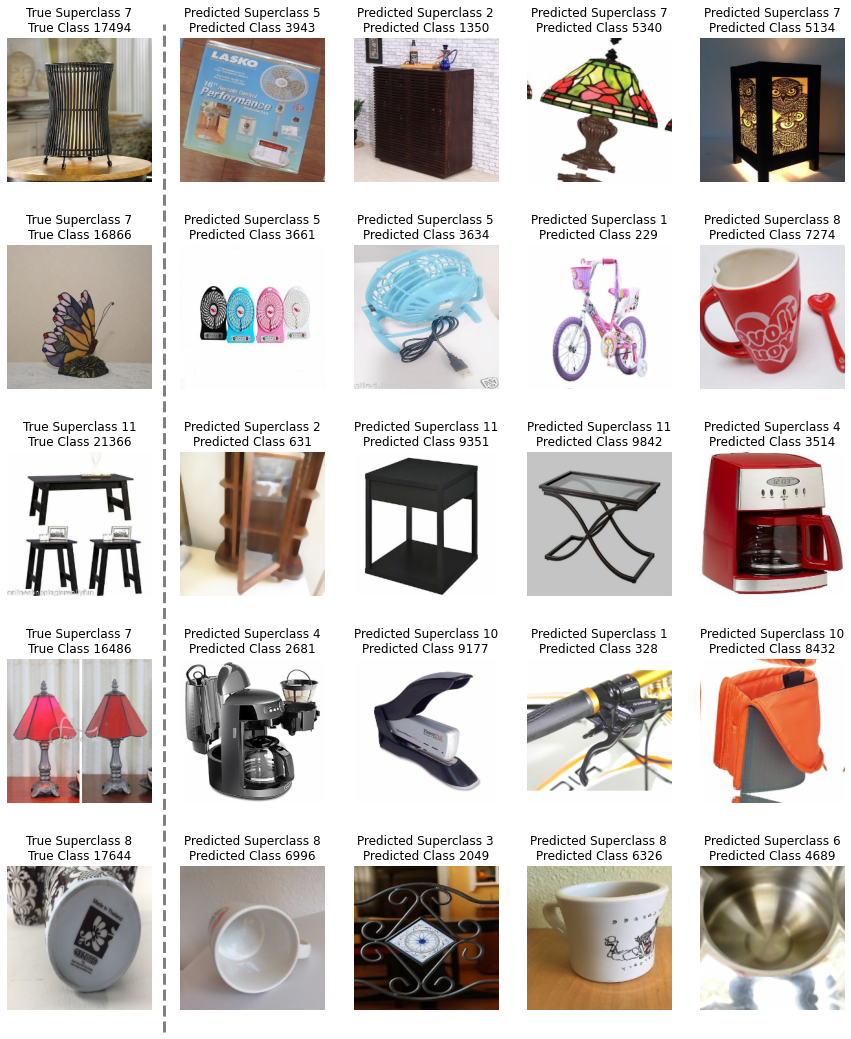

In [ ]:
show_retrieval(plain_resnet18_conf.model, annoy_index, datasets['train'], datasets['test'], k_closest=4)

In [ ]:
models_metrics_df

,Model_Name,Accuracy_Class_ID,Accuracy_Superclass_ID,mAP@5_Class_ID,mAP@5_Superclass_ID
0,plain_resnet18,0.0301,0.2178,0.0342,0.3345


In [ ]:
models_metrics_df.to_csv(f'{GDRIVE_DATA_DIR}/models_metrics_df.csv', index=False)

## Task 2: Fine-tuned with vanilla Cross Entropy and classification approach

In [ ]:
resnet18_cross_entropy_conf = ResNetInitializer(ModelTypes.TUNED_WITH_CROSS_ENTROPY, num_superclasses, num_classes)

### Fine-tune the model

In [ ]:
best_resnet18_cross_entropy, optimizer_ft = fine_tune_model(resnet18_cross_entropy_conf.model, data_loaders, dataset_sizes,
                                                            resnet18_cross_entropy_conf.criterion, resnet18_cross_entropy_conf.optimizer,
                                                            resnet18_cross_entropy_conf.scheduler, num_epochs=4)

Epoch 0/3
----------


100%|██████████| 373/373 [04:03<00:00,  1.53it/s]



train Loss: 10.7316 Acc [Classes]: 0.0001 Acc [Superclasses]: 0.6222


100%|██████████| 94/94 [00:51<00:00,  1.81it/s]



val Loss: 10.1711 Acc [Classes]: 0.0003 Acc [Superclasses]: 0.7414

Epoch 1/3
----------


100%|██████████| 373/373 [03:53<00:00,  1.60it/s]



train Loss: 10.1613 Acc [Classes]: 0.0002 Acc [Superclasses]: 0.7374


100%|██████████| 94/94 [00:47<00:00,  1.97it/s]



val Loss: 9.9134 Acc [Classes]: 0.0012 Acc [Superclasses]: 0.7737

Epoch 2/3
----------


100%|██████████| 373/373 [03:53<00:00,  1.60it/s]



train Loss: 9.9011 Acc [Classes]: 0.0011 Acc [Superclasses]: 0.7662


100%|██████████| 94/94 [00:48<00:00,  1.96it/s]



val Loss: 9.7189 Acc [Classes]: 0.0035 Acc [Superclasses]: 0.7858

Epoch 3/3
----------


100%|██████████| 373/373 [03:51<00:00,  1.61it/s]



train Loss: 9.6714 Acc [Classes]: 0.0034 Acc [Superclasses]: 0.7857


100%|██████████| 94/94 [00:50<00:00,  1.88it/s]


val Loss: 9.5395 Acc [Classes]: 0.0057 Acc [Superclasses]: 0.7936

Training complete in 19m 0s
Best val Acc [Classes]: 0.005709
Bests val Acc [Superclasses]: 0.793552


In [ ]:
# Set model to evaluation mode
best_resnet18_cross_entropy.eval()

checkpoint = {'state_dict': best_resnet18_cross_entropy.state_dict(), 'optimizer': optimizer_ft.state_dict()}
torch.save(checkpoint, f'{GDRIVE_DATA_DIR}/{resnet18_cross_entropy_conf.model_name}_fine_tuned_checkpoint.pth')

### Build an Index

In [ ]:
annoy_index = build_index(best_resnet18_cross_entropy, datasets['train'], INDEX_MODEL_OUTPUT_SIZE,
                          resnet18_cross_entropy_conf.model_name, num_trees=12, data_dir=GDRIVE_DATA_DIR)
annoy_index.get_nns_by_item(0, 5)

100%|██████████| 47640/47640 [08:50<00:00, 89.78it/s]



Number of skipped images because of errors: 0
Number of successfully saved images: 47640


[0, 45453, 26926, 43212, 16042]

### Evaluate the model

Load the best model and optimizer from the last checkpoint

In [ ]:
resnet18_cross_entropy_conf = ResNetInitializer(ModelTypes.TUNED_WITH_CROSS_ENTROPY, num_superclasses, num_classes)
best_resnet18_cross_entropy = resnet18_cross_entropy_conf.model
last_checkpoint = torch.load(f'{GDRIVE_DATA_DIR}/{resnet18_cross_entropy_conf.model_name}_fine_tuned_checkpoint.pth')
optimizer_ft = last_checkpoint['optimizer']
best_resnet18_cross_entropy.load_state_dict(last_checkpoint['state_dict'])
best_resnet18_cross_entropy.eval()

MultilabelClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
annoy_index = load_index(INDEX_MODEL_OUTPUT_SIZE, resnet18_cross_entropy_conf.model_name, datasets['train'], data_dir=GDRIVE_DATA_DIR)

In [ ]:
models_metrics_df = evaluate(best_resnet18_cross_entropy, resnet18_cross_entropy_conf.model_name, models_metrics_df,
                             datasets['train'], datasets['val'], annoy_index, METRICS_K)

100%|██████████| 11911/11911 [06:58<00:00, 28.48it/s]



[resnet18_with_cross_entropy_loss] Accuracy for class_id: 0.387
[resnet18_with_cross_entropy_loss] Accuracy for superclass_id: 0.8213
[resnet18_with_cross_entropy_loss] mAP@5 for class_id: 0.4214
[resnet18_with_cross_entropy_loss] mAP@5 for superclass_id: 0.86


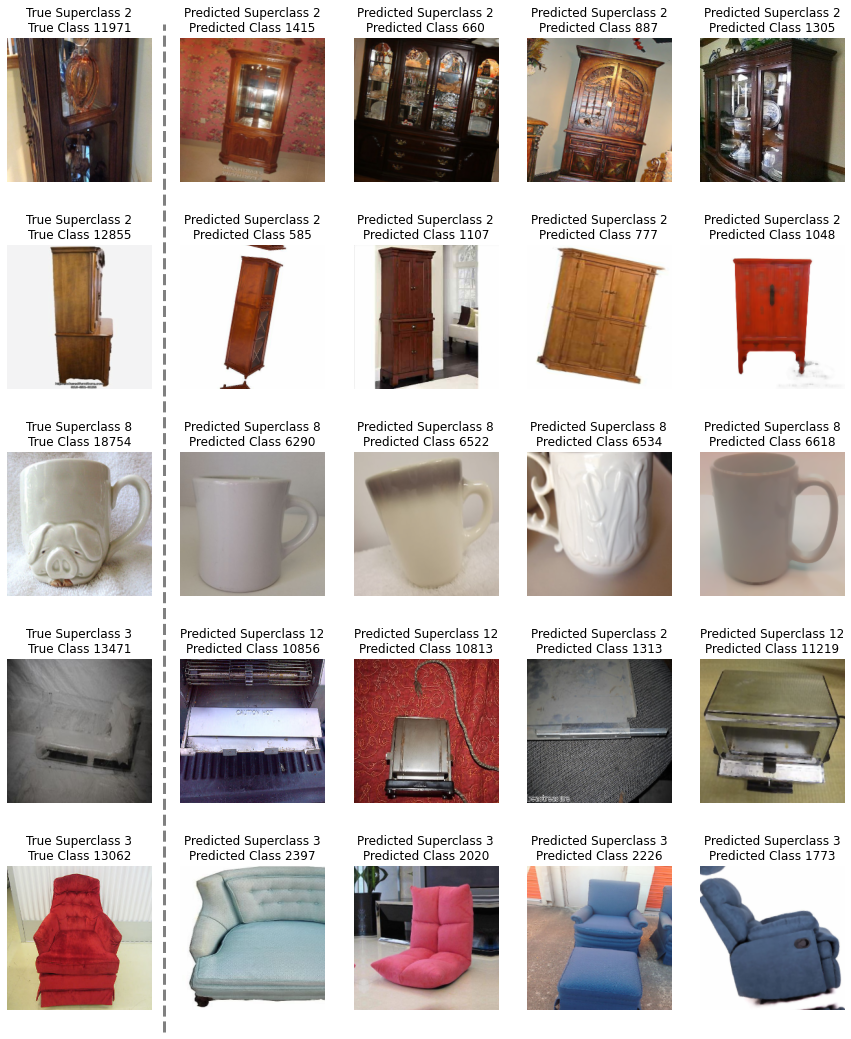

In [ ]:
show_retrieval(best_resnet18_cross_entropy, annoy_index, datasets['train'], datasets['test'], k_closest=4)

In [ ]:
models_metrics_df

,Model_Name,Accuracy_Class_ID,Accuracy_Superclass_ID,mAP@5_Class_ID,mAP@5_Superclass_ID
0,resnet18_with_cross_entropy_loss,0.387,0.8213,0.4214,0.86


In [ ]:
models_metrics_df.to_csv(f'{GDRIVE_DATA_DIR}/{resnet18_cross_entropy_conf.model_name}_models_metrics_df.csv', index=False)